Checking if the 2mmask function made for the files in storeA works correctly on the files in storeB used for the ml project:
$\newline$

Explanation of the code: 

$\newline$
The transformation is an approach following xroms example on xarrays website:
$\newline$
$Z_0 = \frac{h_c \cdot S + h \cdot C}{h_c + h }$
$\newline$
$z = Z_0 (\zeta + h) + \zeta$
$\newline$
This creates a new datacoordinate Z_rho. 

Explanation: 
The code calculates the midpoint of each s-layer depending on which transformation is found in the V-transform. V-transform == 2 is more regulary used for newer ROMS models according to xroms. 
$\newline$
The calculations creates a variable $Z_0$ which is calculated by the use of:
$\newline$
hc = critical depth for stretching 
$\newline$
$s_rho$ = s-layers 
$\newline$
h = total depth
$\newline$
$Cs_r$ = stretching curve for the rho points
$\newline$
$\zeta$ = free surface  
$\newline$

$Z_0$ explains the depth at a given grid cell using the stretching features including the topography, but it excludes the surface layer.
$z_{rho}$ then includes the surface elevation by including $\zeta$ in the calculations and providing the dataset with a new coordinate defining the depth of the grid cells. 

$\newline$
$\newline$

Finding the 2m values:
1. Take the absolute value of the depths (using z_rho) and then subtracting two, to then be able to pick out the resulting numbers closest to zero. Those closest to zero will be the ones near 2meters depth in the model.
2. The diff.fillna function allows us to have zeros as a value for the landvalues rather than nan, as nan gives errors. Though this is corrected later in the code when plotting with seaborn to ensure the land is visibly different from the rest of the plot.  
3. Using argmin, I am selecting out the index of the number closest to zero, to find which s_layer it belongs to. This is why the dimension being called on is s_rho. 
4. Then selecting the index array defined above of those closest to two meters, I use this as an isel, only selecting out these z_rho values to create a new array. 

In [1]:
#Importing necessary datasets
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
#Manually installing seaborn due to problems with the terminal
%pip install seaborn
#pip show seaborn
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Importing the datasets and selecting different timesteps to reduce dataset. 01.06.2024
file1 = f'/lustre/storeB/project/fou/hi/foccus/datasets/symlinks/norkystv3-hindcast/2024/norkyst800-20240601.nc'
ds_norkyst_lavvann = xr.open_dataset(file1, engine="netcdf4").sel(time = '2024-06-01T07:00:00.000000000') #Kartverket kl. 07 - 30cm i vannstand
ds_norkyst_høyvann = xr.open_dataset(file1, engine = "netcdf4").sel(time = '2024-06-01T05:00:00.000000000') #Kartverket kl. 01 - 70cm i vannstand

In [17]:
#check datafile 

"""
Differences between the storeA and storeB files
ocean_time = time 
Vtransform does not exist in the storeB norkystv3_hindcast, has to be removed
I use the equation for model vtransform == 2 because it represents newer models according to xroms, which I am guessing this is 
Otherwhise I think everything should be the same between the datasets
"""
#ds_norkyst_lavvann.time.values

ds_norkyst_lavvann

<xarray.Dataset> Size: 4GB
Dimensions:           (Y: 1148, X: 2747, s_rho: 40, s_w: 41)
Coordinates:
    time              datetime64[ns] 8B 2024-06-01T07:00:00
  * s_rho             (s_rho) float64 320B -0.9799 -0.9403 ... -0.004904
  * X                 (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y                 (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.168e+05 9.176e+05
  * s_w               (s_w) float64 328B -1.0 -0.96 -0.9208 ... -0.01 0.0
    lon               (X, Y) float64 25MB 8.7 8.69 8.679 ... 18.38 18.35 18.33
    lat               (X, Y) float64 25MB 54.29 54.3 54.3 ... 75.72 75.72 75.73
    z_rho             (s_rho, X, Y) float64 1GB nan nan nan ... -0.3934 -0.394
Data variables: (12/18)
    Uwind_eastward    (Y, X) float32 13MB ...
    Vwind_northward   (Y, X) float32 13MB ...
    zeta              (Y, X) float32 13MB ...
    ubar_eastward     (Y, X) float32 13MB ...
    vbar_northward    (Y, X) float32 13MB ...
    u_eastward        (s_rho, Y, X) float32 505MB ...
    ...                ...
    hc                float64 8B ...
    Cs_r              (s_rho) float64 320B ...
    Cs_w              (s_w) float64 328B ...
    h                 (Y, X) float32 13MB ...
    projection_stere  int32 4B ...
    depth             int32 4B ...
Attributes: (12/33)
    id:                      f138d146-d52e-4b15-aa86-fb4f4737380c
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

In [ ]:
def finding_2m_layer(ds_name, title):
    #Define necessary variables used for the transformation from s_layer to depth
    hc = ds_name["hc"] #Critical depth for stretching
    cs_r = ds_name["Cs_r"] #stretching curve at rho points
    zeta = ds_name["zeta"] #.fillna(0) #free-surface 
    H = ds_name["h"] #bathymetry at rho-points (depth)
    #Vtransform = ds_name["Vtransform"] Not in this dataset
    s_rho = ds_name["s_rho"] #range 1,40. 40 is surface layer

    #Transformation process
    #if Vtransform == 1:
        #Z_0_rho = hc * (s_rho - cs_r) + cs_r * H
        #z_rho = Z_0_rho + zeta * (1+Z_0_rho/H)
    #elif Vtransform == 2:
    Z_0_rho = (hc * s_rho + cs_r * H) / (hc + H)
    z_rho = zeta + (zeta + H) * Z_0_rho

    ds_name.coords["z_rho"] = z_rho.transpose() #Corrects the dimensions

    #calculating the 2meters depth and creating two new arrays. One controlrun
    #for the actual values and one array containing the indexes of the values. 
    #If one wants to find for other depths than 2 meters, replace the calculatipon of diff with the new value. 
    z_rho_pos = abs(ds_name["z_rho"])
    diff = abs(z_rho_pos-2) #2meter
    diff = diff.fillna(0)
    index = diff.argmin(dim = "s_rho")
    close_to_2m_val = z_rho.isel(s_rho=index)
    #zero = nan in plot
    index = index.where(index != 0)
    ax = sns.heatmap(np.array(index)[::-1,::-1], vmin=25, cbar_kws={'label': 'Index'})
    ax.set_title(title)
    return index, close_to_2m_val, ax


(<xarray.DataArray 'z_rho' (X: 2747, Y: 1148)> Size: 25MB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [39., 39., 39., ..., 37., 37., 37.],
        [39., 39., 39., ..., 37., 37., 37.],
        [39., 39., 39., ..., 37., 37., 37.]], shape=(2747, 1148))
 Coordinates:
     time     datetime64[ns] 8B 2024-06-01T07:00:00
   * X        (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
   * Y        (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.16e+05 9.168e+05 9.176e+05
     lon      (X, Y) float64 25MB 8.7 8.69 8.679 8.669 ... 18.4 18.38 18.35 18.33
     lat      (X, Y) float64 25MB 54.29 54.3 54.3 54.3 ... 75.72 75.72 75.73,
 <xarray.DataArray (Y: 1148, X: 2747)> Size: 25MB
 array([[        nan,         nan,         nan, ..., -1.76364894,
         -1.76369181, -1.76369473],
        [        nan,         nan,         nan, ..., -1.76362694,
         -1.76366426, -1.76366487],
    

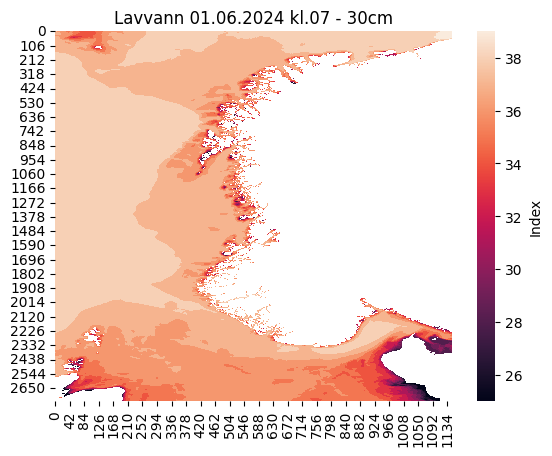

In [6]:
finding_2m_layer(ds_norkyst_lavvann, title="Lavvann 01.06.2024 kl.07 - 30cm")

(<xarray.DataArray 'z_rho' (X: 2747, Y: 1148)> Size: 25MB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [38., 38., 38., ..., 37., 37., 37.],
        [38., 38., 38., ..., 37., 37., 37.],
        [38., 38., 38., ..., 37., 37., 37.]], shape=(2747, 1148))
 Coordinates:
     time     datetime64[ns] 8B 2024-06-01T05:00:00
   * X        (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
   * Y        (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.16e+05 9.168e+05 9.176e+05
     lon      (X, Y) float64 25MB 8.7 8.69 8.679 8.669 ... 18.4 18.38 18.35 18.33
     lat      (X, Y) float64 25MB 54.29 54.3 54.3 54.3 ... 75.72 75.72 75.73,
 <xarray.DataArray (Y: 1148, X: 2747)> Size: 25MB
 array([[        nan,         nan,         nan, ..., -2.16471138,
         -2.16485178, -2.16486135],
        [        nan,         nan,         nan, ..., -2.16463933,
         -2.16476157, -2.16476354],
    

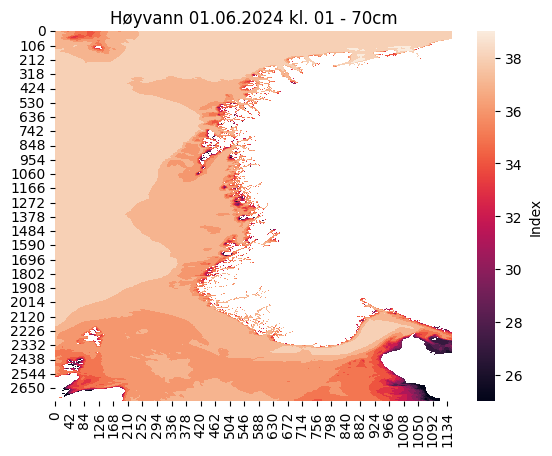

In [7]:
finding_2m_layer(ds_norkyst_høyvann, title="Høyvann 01.06.2024 kl. 01 - 70cm")

In [8]:
#Adding a later year to see wether there are many changes or not
#Same date but in 2018 and 2012

In [9]:
file_2 = f'/lustre/storeB/project/fou/hi/foccus/datasets/symlinks/norkystv3-hindcast/2018/norkyst800-20180601.nc'
file_3 = f'/lustre/storeB/project/fou/hi/foccus/datasets/symlinks/norkystv3-hindcast/2012/norkyst800-20120601.nc'

In [10]:
ds_norkyst_høyvann_2018 = xr.open_dataset(file_2, engine="netcdf4").sel(time = '2018-06-01T20:00:00.000000000')
ds_norkyst_høyvann_2012 = xr.open_dataset(file_3, engine="netcdf4").sel(time = '2012-06-01T15:00:00.000000000' )
ds_norkyst_lavvann_2018 = xr.open_dataset(file_2, engine="netcdf4").sel(time = '2018-06-01T01:00:00.000000000')
ds_norkyst_lavvann_2012 = xr.open_dataset(file_3, engine = "netcdf4").sel(time = '2012-06-01T08:00:00.000000000' )

In [11]:
ds_norkyst_høyvann_2012.time
#lavvannet og høyvannet var ikke veldig markant denne dagen, men har likevel tatt med de to tidspunktene som skiller seg mest ut

<xarray.DataArray 'time' ()> Size: 8B
array('2012-06-01T15:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2012-06-01T15:00:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time

(<xarray.DataArray 'z_rho' (X: 2747, Y: 1148)> Size: 25MB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [38., 38., 38., ..., 36., 36., 36.],
        [38., 38., 38., ..., 36., 36., 36.],
        [38., 38., 38., ..., 36., 36., 36.]], shape=(2747, 1148))
 Coordinates:
     time     datetime64[ns] 8B 2012-06-01T08:00:00
   * X        (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
   * Y        (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.16e+05 9.168e+05 9.176e+05
     lon      (X, Y) float64 25MB 8.7 8.69 8.679 8.669 ... 18.4 18.38 18.35 18.33
     lat      (X, Y) float64 25MB 54.29 54.3 54.3 54.3 ... 75.72 75.72 75.73,
 <xarray.DataArray (Y: 1148, X: 2747)> Size: 25MB
 array([[        nan,         nan,         nan, ..., -2.22439349,
         -2.22453396, -2.22454354],
        [        nan,         nan,         nan, ..., -2.22432139,
         -2.2244437 , -2.22444567],
    

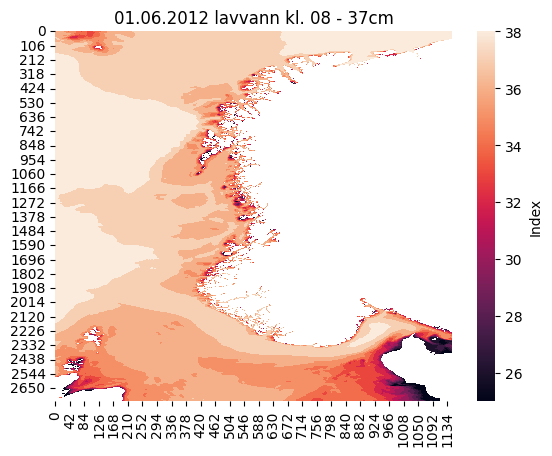

In [12]:
finding_2m_layer(ds_norkyst_lavvann_2012, title="01.06.2012 lavvann kl. 08 - 37cm")

(<xarray.DataArray 'z_rho' (X: 2747, Y: 1148)> Size: 25MB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [36., 36., 36., ..., 38., 38., 38.],
        [36., 36., 36., ..., 38., 38., 38.],
        [36., 36., 36., ..., 38., 38., 38.]], shape=(2747, 1148))
 Coordinates:
     time     datetime64[ns] 8B 2012-06-01T15:00:00
   * X        (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
   * Y        (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.16e+05 9.168e+05 9.176e+05
     lon      (X, Y) float64 25MB 8.7 8.69 8.679 8.669 ... 18.4 18.38 18.35 18.33
     lat      (X, Y) float64 25MB 54.29 54.3 54.3 54.3 ... 75.72 75.72 75.73,
 <xarray.DataArray (Y: 1148, X: 2747)> Size: 25MB
 array([[        nan,         nan,         nan, ..., -1.67978117,
         -1.68016661, -1.68019289],
        [        nan,         nan,         nan, ..., -1.67958336,
         -1.67991894, -1.67992435],
    

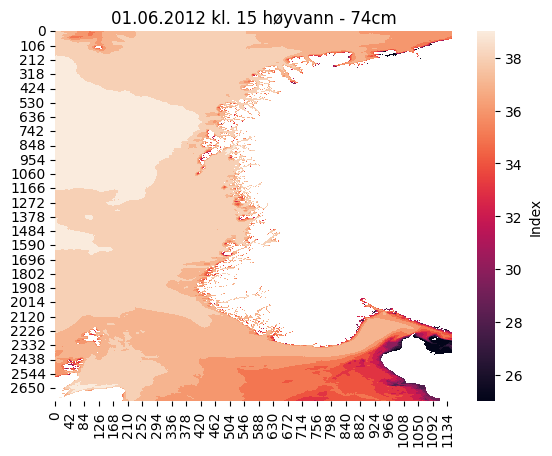

In [13]:
finding_2m_layer(ds_norkyst_høyvann_2012, title="01.06.2012 kl. 15 høyvann - 74cm")

(<xarray.DataArray 'z_rho' (X: 2747, Y: 1148)> Size: 25MB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [36., 36., 36., ..., 38., 38., 38.],
        [36., 36., 36., ..., 38., 38., 38.],
        [36., 36., 36., ..., 38., 38., 38.]], shape=(2747, 1148))
 Coordinates:
     time     datetime64[ns] 8B 2018-06-01T20:00:00
   * X        (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
   * Y        (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.16e+05 9.168e+05 9.176e+05
     lon      (X, Y) float64 25MB 8.7 8.69 8.679 8.669 ... 18.4 18.38 18.35 18.33
     lat      (X, Y) float64 25MB 54.29 54.3 54.3 54.3 ... 75.72 75.72 75.73,
 <xarray.DataArray (Y: 1148, X: 2747)> Size: 25MB
 array([[        nan,         nan,         nan, ..., -1.67978117,
         -1.68016661, -1.68019289],
        [        nan,         nan,         nan, ..., -1.67958336,
         -1.67991894, -1.67992435],
    

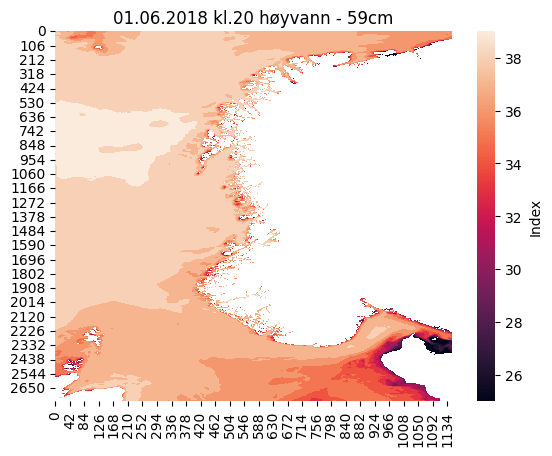

In [14]:
finding_2m_layer(ds_norkyst_høyvann_2018, title="01.06.2018 kl.20 høyvann - 59cm")

(<xarray.DataArray 'z_rho' (X: 2747, Y: 1148)> Size: 25MB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [39., 39., 39., ..., 36., 36., 36.],
        [39., 39., 39., ..., 36., 36., 36.],
        [39., 39., 39., ..., 36., 36., 36.]], shape=(2747, 1148))
 Coordinates:
     time     datetime64[ns] 8B 2018-06-01T01:00:00
   * X        (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
   * Y        (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.16e+05 9.168e+05 9.176e+05
     lon      (X, Y) float64 25MB 8.7 8.69 8.679 8.669 ... 18.4 18.38 18.35 18.33
     lat      (X, Y) float64 25MB 54.29 54.3 54.3 54.3 ... 75.72 75.72 75.73,
 <xarray.DataArray (Y: 1148, X: 2747)> Size: 25MB
 array([[        nan,         nan,         nan, ..., -1.92338078,
         -1.92342371, -1.92342664],
        [        nan,         nan,         nan, ..., -1.92335874,
         -1.92339612, -1.92339673],
    

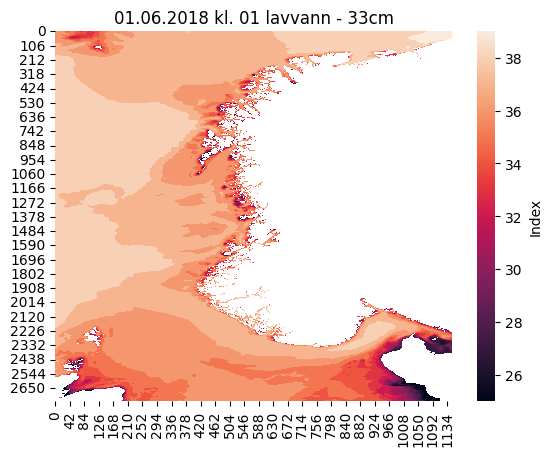

In [15]:
finding_2m_layer(ds_norkyst_lavvann_2018, title="01.06.2018 kl. 01 lavvann - 33cm")

In [45]:
#Controlcheck -> checking wether the values from the non-transformed dataset corresponds with the values that have been transformed. 
ds_norkyst_lavvann_2018.sel(X = 800, Y = 800 )

<xarray.Dataset> Size: 3kB
Dimensions:           (s_rho: 40, s_w: 41)
Coordinates:
    time              datetime64[ns] 8B 2018-06-01T01:00:00
  * s_rho             (s_rho) float64 320B -0.9799 -0.9403 ... -0.004904
    X                 float64 8B 800.0
    Y                 float64 8B 800.0
  * s_w               (s_w) float64 328B -1.0 -0.96 -0.9208 ... -0.01 0.0
    lon               float64 8B 8.695
    lat               float64 8B 54.3
    z_rho             (s_rho) float64 320B nan nan nan nan ... nan nan nan nan
Data variables: (12/18)
    Uwind_eastward    float32 4B ...
    Vwind_northward   float32 4B ...
    zeta              float32 4B ...
    ubar_eastward     float32 4B ...
    vbar_northward    float32 4B ...
    u_eastward        (s_rho) float32 160B ...
    ...                ...
    hc                float64 8B ...
    Cs_r              (s_rho) float64 320B ...
    Cs_w              (s_w) float64 328B ...
    h                 float32 4B ...
    projection_stere  int32 4B ...
    depth             int32 4B ...
Attributes: (12/33)
    id:                      4a4de666-da61-43b0-bdc8-430a4f67d0ba
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

In [42]:
#Seperate the functions, one that transforms and one that plots:
#for time effiency 

def transformation(ds_name):
    #Define necessary variables used for the transformation from s_layer to depth
    hc = ds_name["hc"] #Critical depth for stretching
    cs_r = ds_name["Cs_r"] #stretching curve at rho points
    zeta = ds_name["zeta"] #.fillna(0) #free-surface 
    H = ds_name["h"] #bathymetry at rho-points (depth)
    #Vtransform = ds_name["Vtransform"] Not in this dataset
    s_rho = ds_name["s_rho"] #range 1,40. 40 is surface layer

    #Transformation process
    #if Vtransform == 1:
        #Z_0_rho = hc * (s_rho - cs_r) + cs_r * H
        #z_rho = Z_0_rho + zeta * (1+Z_0_rho/H)
    #elif Vtransform == 2:
    Z_0_rho = (hc * s_rho + cs_r * H) / (hc + H)
    z_rho = zeta + (zeta + H) * Z_0_rho

    ds_name.coords["z_rho"] = z_rho.transpose() #Corrects the dimensions
    return z_rho

def plot_the_2m_layer(ds_name, title):
    transformation(ds_name=ds_name)
    z_rho = ds_name["z_rho"]
    z_rho_pos = abs(ds_name["z_rho"])
    diff = abs(z_rho_pos-2) #2meter
    diff = diff.fillna(0)
    index = diff.argmin(dim = "s_rho")
    close_to_2m_val = z_rho.isel(s_rho=index)
    #zero = nan in plot
    index = index.where(index != 0)
    ax = sns.heatmap(np.array(index)[::-1,::-1], vmin=25, cbar_kws={'label': 'Index'})
    ax.set_title(title)
    return index, close_to_2m_val, ax


In [43]:
finding_2m_layer(ds_norkyst_lavvann_2018)

<xarray.DataArray (Y: 1148, X: 2747, s_rho: 40)> Size: 1GB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-1.92131167e+02, -1.86268194e+02, -1.78979510e+02, ...,
         -3.39429979e+00, -2.62227442e+00, -1.92338078e+00],
        [-1.92203349e+02, -1.86338387e+02, -1.79046975e+02, ...,
         -3.39455686e+00, -2.62241540e+00, -1.92342371e+00],
        [-1.92208273e+02, -1.86343175e+02, -1.79051577e+02, ...,
         -3.39457439e+00, -2.62242502e+00, -1.92342664e+00]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
         -1.37123872e+00, -6.90169641e-01, -6.90031132e-02],
        [-1.35805713e+02, -1.31459757e+02, -1.26233459e+02, ...,
         -1.36293652e+00, -6.89945459e-01, -7.58303325e-02],
        [-1.33860309e+02, -1.29569671e+02, -1.24417140e+02, ...,
         -1.35288604e+00, -6.84326664e-01, -7.40853778e-02]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-1.40216329e+02, -1.35744940e+02, -1.30351057e+02, ...,
         -1.37528740e+00, -6.92429358e-01, -6.97037351e-02],
        [-1.36505972e+02, -1.32140124e+02, -1.26887277e+02, ...,
         -1.36651744e+00, -6.91946531e-01, -7.64515106e-02],
        [-1.34488550e+02, -1.30180038e+02, -1.25003684e+02, ...,
         -1.35614828e+00, -6.86150836e-01, -7.46520077e-02]]],
      shape=(1148, 2747, 40))
Coordinates:
    time     datetime64[ns] 8B 2018-06-01T01:00:00
  * X        (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y        (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.16e+05 9.168e+05 9.176e+05
    lon      (Y, X) float64 25MB 8.7 8.706 8.711 8.717 ... 18.29 18.31 18.33
    lat      (Y, X) float64 25MB 54.29 54.3 54.31 54.31 ... 75.71 75.72 75.73
  * s_rho    (s_rho) float64 320B -0.9799 -0.9403 -0.9014 ... -0.01529 -0.004904

In [85]:
#Funker men output har bare kollapset
plot_the_2m_layer(ds_norkyst_lavvann_2018,title="forsøk på å dele opp funk")

KeyboardInterrupt: 

In [ ]:
#s_rho remains the same at least through the calculations, so one would think the indexing of the layers remains correct
try_1 = transformation(ds_norkyst_lavvann_2018)
try_1.s_rho.values

array([-0.97990385, -0.94028846, -0.90144231, -0.86336538, -0.82605769,
       -0.78951923, -0.75375   , -0.71875   , -0.68451923, -0.65105769,
       -0.61836538, -0.58644231, -0.55528846, -0.52490385, -0.49528846,
       -0.46644231, -0.43836538, -0.41105769, -0.38451923, -0.35875   ,
       -0.33375   , -0.30951923, -0.28605769, -0.26336538, -0.24144231,
       -0.22028846, -0.19990385, -0.18028846, -0.16144231, -0.14336538,
       -0.12605769, -0.10951923, -0.09375   , -0.07875   , -0.06451923,
       -0.05105769, -0.03836538, -0.02644231, -0.01528846, -0.00490385])

In [88]:
ds_norkyst_lavvann_2018.s_rho.values

array([-0.97990385, -0.94028846, -0.90144231, -0.86336538, -0.82605769,
       -0.78951923, -0.75375   , -0.71875   , -0.68451923, -0.65105769,
       -0.61836538, -0.58644231, -0.55528846, -0.52490385, -0.49528846,
       -0.46644231, -0.43836538, -0.41105769, -0.38451923, -0.35875   ,
       -0.33375   , -0.30951923, -0.28605769, -0.26336538, -0.24144231,
       -0.22028846, -0.19990385, -0.18028846, -0.16144231, -0.14336538,
       -0.12605769, -0.10951923, -0.09375   , -0.07875   , -0.06451923,
       -0.05105769, -0.03836538, -0.02644231, -0.01528846, -0.00490385])